
📂 Fold 1/5


 26%|██▋       | 265/1000 [05:15<14:35,  1.19s/it]

Early stopping at epoch 266
✅ Fold 1 — Best Epoch: 196 | MSE: 0.1109 | MAPE: 0.1676


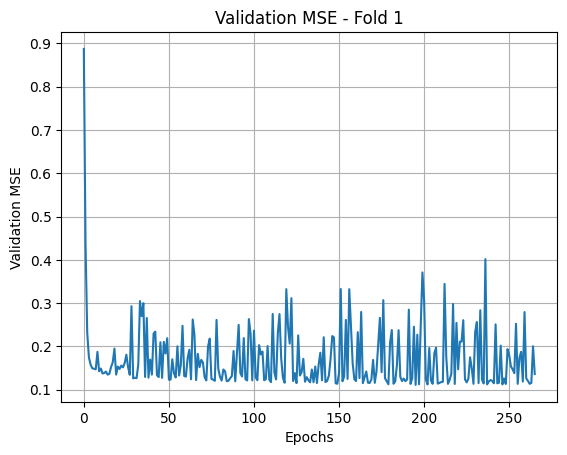


📂 Fold 2/5


 24%|██▍       | 243/1000 [04:50<15:03,  1.19s/it]

Early stopping at epoch 244
✅ Fold 2 — Best Epoch: 174 | MSE: 0.1115 | MAPE: 0.1693


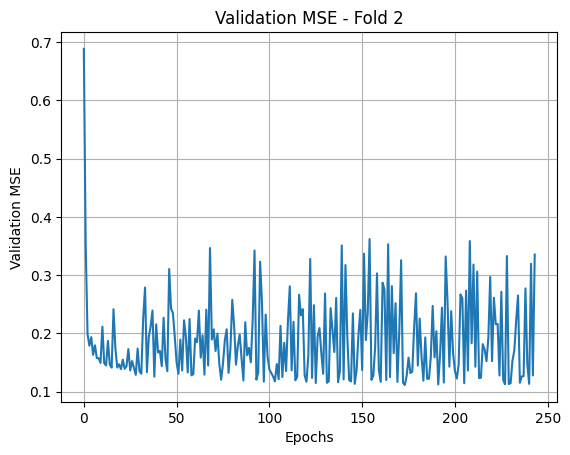


📂 Fold 3/5


 34%|███▍      | 341/1000 [06:46<13:05,  1.19s/it]

Early stopping at epoch 342
✅ Fold 3 — Best Epoch: 272 | MSE: 0.1053 | MAPE: 0.1662


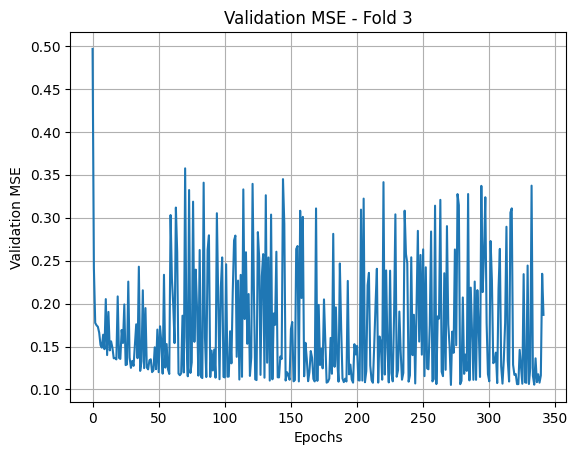


📂 Fold 4/5


 50%|████▉     | 498/1000 [09:54<09:59,  1.19s/it]

Early stopping at epoch 499
✅ Fold 4 — Best Epoch: 429 | MSE: 0.1078 | MAPE: 0.1641


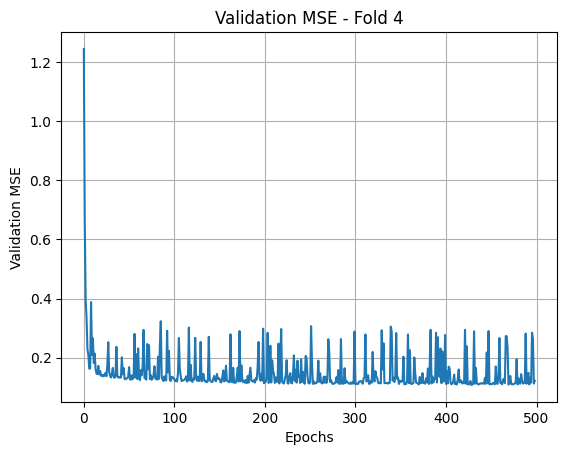


📂 Fold 5/5


 34%|███▍      | 344/1000 [06:48<12:59,  1.19s/it]

Early stopping at epoch 345
✅ Fold 5 — Best Epoch: 275 | MSE: 0.1163 | MAPE: 0.1682


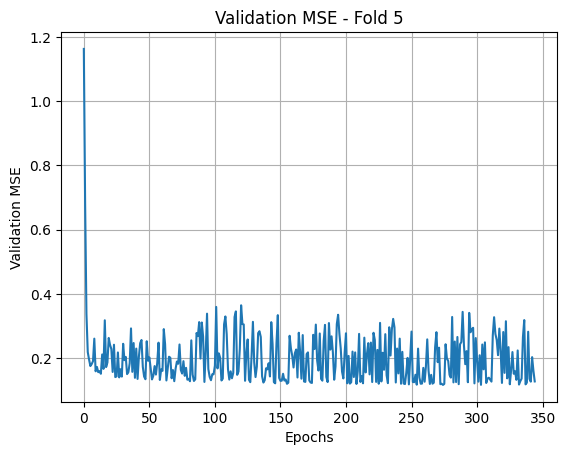


🏁 Overall Best Result:
Best Fold: 3
Best MSE: 0.1053
Best MAPE: 0.1662


In [4]:
# Install dependencies
#!pip install torchmetrics

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler,QuantileTransformer
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError
import tqdm
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 64

dataset = fetch_california_housing()

target = dataset.target
lower_bound = np.percentile(target, 1)
upper_bound = np.percentile(target, 99)

# Create a mask for filtering
mask = (target >= lower_bound) & (target <= upper_bound)

# Apply mask to data and target
X = dataset.data[mask]
y = target[mask]

kf = KFold(n_splits=5, shuffle=True, random_state=123)

best_overall_mse = float('inf')
best_overall_mape = None
best_fold = None

EPOCHS = 1000
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n📂 Fold {fold+1}/5")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    scaler = QuantileTransformer(output_distribution='normal')
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Define model for this fold
    model = nn.Sequential(
        nn.Linear(8, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(100, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, 1)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.SmoothL1Loss()
    mape = MeanAbsolutePercentageError()

    loss_list = np.zeros((EPOCHS,))
    mse_list = np.zeros((EPOCHS,))
    mape_list = np.zeros((EPOCHS,))

    best_val_loss = float('inf')
    patience = 70
    min_delta = 1e-5
    patience_counter = 0

    for epoch in tqdm.trange(EPOCHS):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
            epoch_loss += loss.item() * xb.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list[epoch] = epoch_loss / len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_test)
            val_loss = loss_fn(y_pred_val, y_test).item()
            mse_list[epoch] = val_loss
            mape_list[epoch] = mape(y_pred_val, y_test).item()

        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)

    best_epoch = np.argmin(mse_list[:epoch+1])
    best_mse = mse_list[best_epoch]
    best_mape = mape_list[best_epoch]

    print(f"✅ Fold {fold+1} — Best Epoch: {best_epoch+1} | MSE: {best_mse:.4f} | MAPE: {best_mape:.4f}")
    if best_mse < best_overall_mse:
        best_overall_mse = best_mse
        best_overall_mape = best_mape
        best_fold = fold + 1
    plt.plot(mse_list[:epoch+1])
    plt.title(f"Validation MSE - Fold {fold+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Validation MSE")
    plt.grid(True)
    plt.show()

print("\n🏁 Overall Best Result:")
print(f"Best Fold: {best_fold}")
print(f"Best MSE: {best_overall_mse:.4f}")
print(f"Best MAPE: {best_overall_mape:.4f}")

# VAL

Best MSE: 0.1040
Best MAPE: 0.1619